# Fetal lung and panfetal analysis - Milo differential abundance analysis

In this notebook I take the integrated immune lung and pan-fetal immune datasets after scVI and run Milo analysis to find neighbourhoods of cells enriched in lung compared to all other organs

In [1]:
import os,sys
import scanpy as sc
import scvi
import numpy as np
import pandas as pd
import numpy.random as random
import scipy
from scipy.sparse import csr_matrix
import anndata
import matplotlib.pyplot as plt

import milopy

Global seed set to 0


In [2]:
import seaborn as sns
import scvelo as scv

In [5]:
## r2py setup
# import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# anndata2ri.activate()

In [6]:
%load_ext rpy2.ipython


In [7]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


## Load integrated object

From `lung_panfetal_integration.ipynb`

In [ ]:
data_dir = '/home/jovyan/mount/gdrive/fetal_immune_lung_intergration/'
adata = sc.read_h5ad(data_dir + 'Lung_panfetal_merged.scVI.V3.h5ad')

### Plot embedding

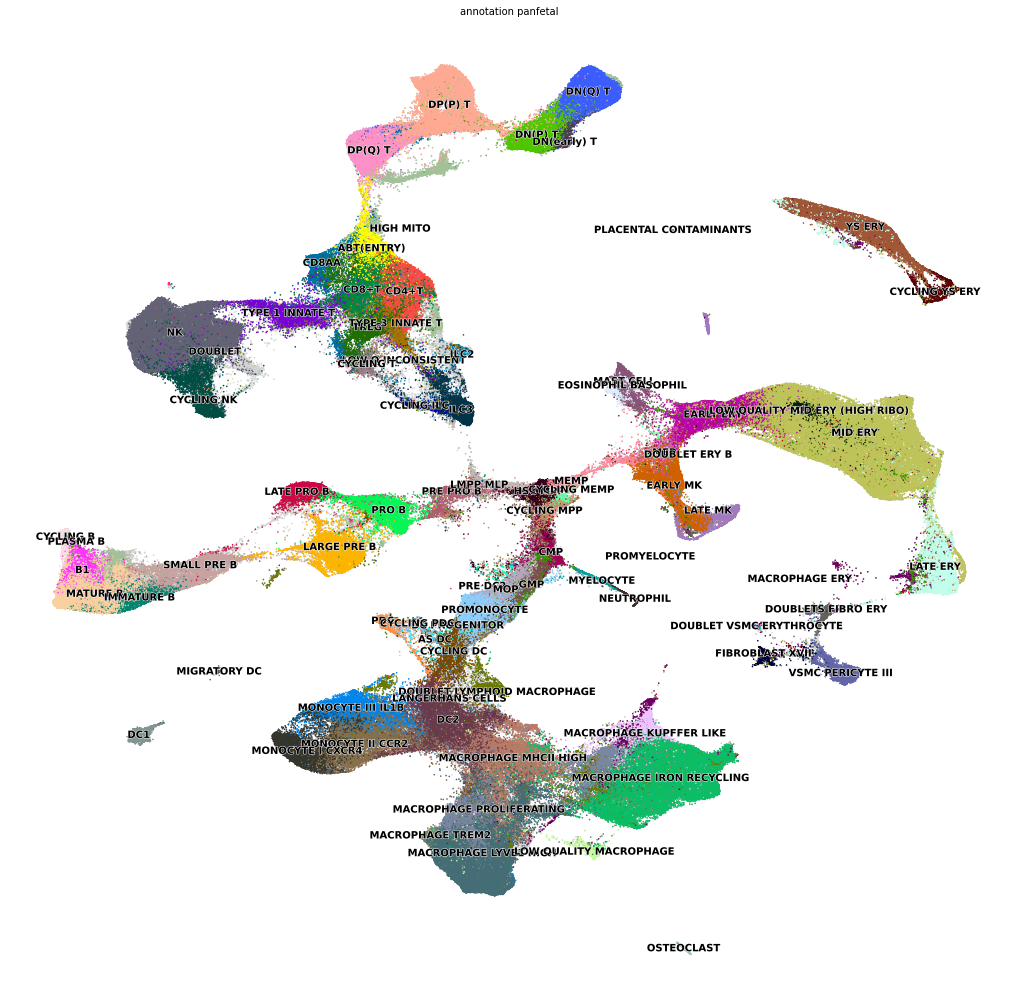

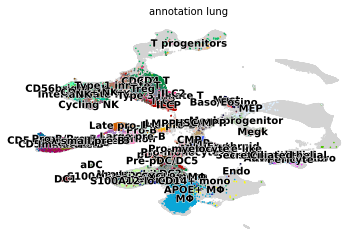

In [9]:
plt.rcParams['figure.figsize'] = [18,18]
labels = [x for x in adata.obs['celltype_annotation'].unique().tolist() if x != 'nan']
scv.pl.umap(adata,color=['celltype_annotation'], size=10, groups=labels,
           title=['annotation panfetal'], legend_loc='on data', ncols=1)
labels = [x for x in adata.obs['celltype'].unique().tolist() if x != 'nan']
scv.pl.umap(adata,color=['celltype'], size=10, groups=labels,
           title=['annotation lung'], legend_loc='on data', ncols=1)

In [10]:
# from adjustText import adjust_text
# def gen_mpl_labels(
#     adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None
# ):
#     if adjust_kwargs is None:
#         adjust_kwargs = {"text_from_points": False}
#     if text_kwargs is None:
#         text_kwargs = {}

#     medians = {}

#     for g, g_idx in adata.obs.groupby(groupby).groups.items():
#         if g in exclude:
#             continue
#         medians[g] = np.median(adata[g_idx].obsm["X_umap"], axis=0)

#     if ax is None:
#         texts = [
#             plt.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()
#         ]
#     else:
#         texts = [ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()]

#     adjust_text(texts, **adjust_kwargs)
    
# def plot_umap_repel(merged_adata, color_obs, save=False, **kwargs):
#     ax = sc.pl.umap(merged_adata, color=color_obs, 
#                 show=False, legend_loc=None, **kwargs)
#     gen_mpl_labels(
#         merged_adata,
#         color_obs,
#         # exclude=merged_adata.obs['annotation_reference'][~merged_adata.obs['annotation_reference'].isin(anno_labels)].unique().tolist(),
#         ax=ax,
#         adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
#         text_kwargs=dict(fontsize=18, fontweight='bold'),
#     )
#     fig = ax.get_figure()
#     fig.tight_layout()
#     if save:
#         plt.savefig(figdir+"anno_query_fixedlabels.png")
#     else:
#         plt.show()
        

# plot_umap_repel(adata, color_obs = 'celltype_annotation', size=10, palette=sc.pl.palettes.godsnot_102,legend_fontsize=14, frameon=False,
#                 title="Annotation panfetal")

### Transfer labels
By KNN classifier

In [ ]:
import sys
sys.path.append('/home/jovyan/Pan_fetal_immune/src/utils/scArches_utils/')
import map_query_utils

adata.obs["dataset"] = ['query' if x=='lung' else 'reference' for x in adata.obs["dataset"]]

In [ ]:
def predict_labels3(sdata, k=100, anno_col = 'celltype_annotation'):
    import time
    from scipy.spatial import cKDTree

    ## Extract embedding
    X_emb = sdata.obsm["X_scvi"].copy()

    is_query = sdata.obs["dataset"] == "query"
    is_reference = sdata.obs["dataset"] == "reference"

    X_emb_ref = X_emb[is_reference,:]
    X_emb_que = X_emb[is_query,:]

    ## Find nearest neighbors in reference
    k1=k2=k
    data_query = X_emb_que
    data_ref = X_emb_ref
    start = time.time()
    k_index_ref = cKDTree(data_ref).query(x=data_query, k=k1, n_jobs=5)[1]
    end = time.time()
    print(end - start)
    
    ## Extract reference annotations
    annos = sdata.obs[anno_col][is_reference]
    all_labels = annos.unique()
    n_labels = annos.unique().shape[0]
    
    ## Extract annotations of nearest neighbors
    annos_nns = np.take(annos.values.astype("str"), k_index_ref)
    predicted_anno = []
    predicted_anno_probability = []
    for i in range(k_index_ref.shape[0]):
        labels_nn, count_labels_nn = np.unique(annos_nns[i,:], return_counts=True)
        predicted_anno.append(labels_nn[count_labels_nn.argmax()])
        predicted_anno_probability.append(count_labels_nn.max()/k)

    sdata.obs['predicted_anno'] = np.nan
    sdata.obs['predicted_anno_probability'] = np.nan
    sdata.obs.loc[is_query,'predicted_anno'] = predicted_anno
    sdata.obs.loc[is_query,'predicted_anno_probability'] = predicted_anno_probability

In [ ]:
predict_labels3(adata)

In [ ]:
adata.obs['predicted_anno_prob'] = adata.obs['predicted_anno_probability']

In [ ]:
plt.rcParams['figure.figsize'] = [8,18]
map_query_utils.plot_predicted_anno_probability(adata)

In [ ]:
plt.rcParams['figure.figsize'] = [16,12]
map_query_utils.plot_confusion_mat(adata, query_anno_col='celltype')

In [18]:
adata.write_h5ad()

### Differential abundance analysis

In [10]:
import milopy

In [18]:
adata.obs['dataset_DA'] = adata.obs['dataset'].astype('category').cat.reorder_categories(['reference', 'query']).cat.codes

adata.obs['age'] = adata.obs['age'].astype('float')
adata.obs.loc[adata.obs['age'].isna(), 'age'] = adata.obs.loc[adata.obs['age'].isna(), 'stage'].astype('float')

adata.obs['organ'] = adata.obs['organ'].astype('str')
adata.obs.loc[adata.obs['organ'] == 'nan', 'organ'] = 'LU'

In [66]:
adata.obs.loc[adata.obs['Sort_id']=='nan', 'Sort_id'] = np.where(adata.obs['project'][adata.obs['Sort_id']=='nan'] == 'UCL', 'CD45P', 'TOT')
adata.obs['Sort_id'] = [x if x != 'CD45P_CD45N' else "CD45P" for x in adata.obs['Sort_id']]
adata = adata[adata.obs['Sort_id'].isin(['CD45P', 'CD45N', 'TOT'])].copy()

<AxesSubplot:xlabel='organ', ylabel='age'>

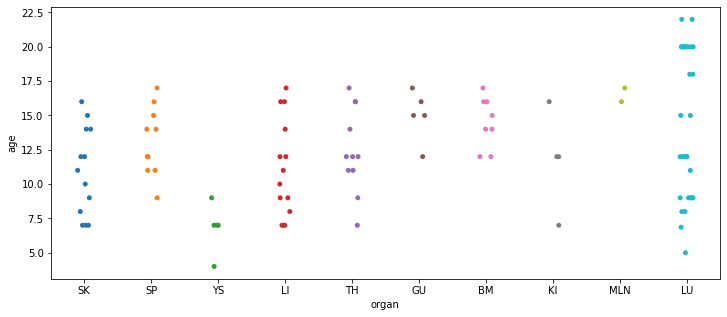

In [67]:
df = adata.obs[['donor', 'organ', 'age']].drop_duplicates()
sns.stripplot(data=df, x='organ', y='age')

In [68]:
## Increase K to have sufficient no of cells per neighbourhood
sc.pp.neighbors(adata, use_rep='X_scvi', n_neighbors=100, key_added='milo')

In [73]:
## Make nhoods
milopy.core.make_nhoods(adata, prop=0.01, neighbors_key='milo')

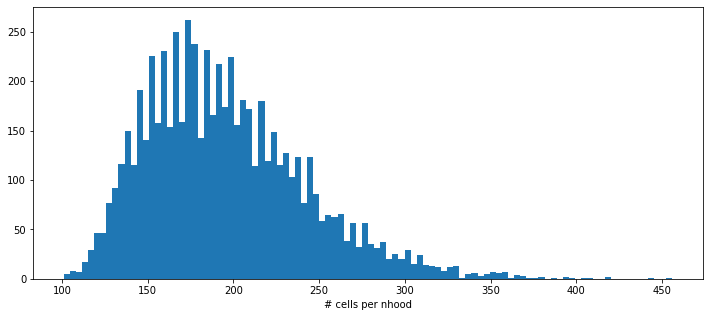

In [74]:
nhood_size = np.array(adata.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100);
plt.xlabel("# cells per nhood");

Text(0.5, 0, '# nhoods per cell')

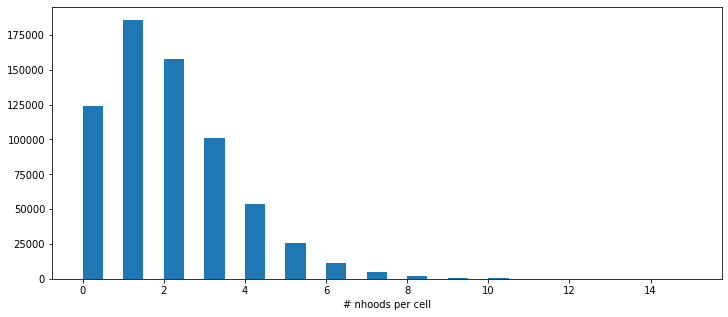

In [75]:
plt.hist(np.array(adata.obsm['nhoods'].sum(1)).ravel(), bins=30);
plt.xlabel("# nhoods per cell")

In [96]:
## Count cells
adata.obs['sample_4_DA'] = np.where(adata.obs['Sample']=='nan', adata.obs['donor'], adata.obs["Sample"])
milopy.core.count_nhoods(adata, sample_col='sample_4_DA')

In [97]:
## Subset to lung samples in the same age range
milopy.utils.add_covariate_to_nhoods_var(adata, ['age'])
adata.uns['nhood_adata'].var['age'] = adata.uns['nhood_adata'].var['age'].astype('float') 
test_donors = adata.uns['nhood_adata'].var_names[adata.uns['nhood_adata'].var['age'] < 18]

In [98]:
## Test
milopy.core.DA_nhoods(adata, design='~ Sort_id + dataset_DA', 
                      subset_samples=test_donors.tolist()
                     )

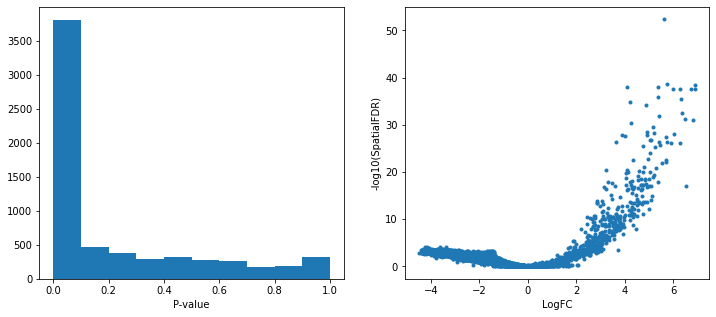

In [99]:
plt.rcParams['figure.figsize'] = [12,5]
nhood_adata = adata.uns['nhood_adata'].copy()
plt.subplot(1,2,1);
plt.hist(nhood_adata.obs['PValue']);
plt.xlabel("P-value");
plt.subplot(1,2,2);
plt.plot(nhood_adata.obs['logFC'], - np.log10(nhood_adata.obs['SpatialFDR']), '.');
plt.xlabel("LogFC");
plt.ylabel("-log10(SpatialFDR)");

In [100]:
milopy.utils.build_nhood_graph(adata)

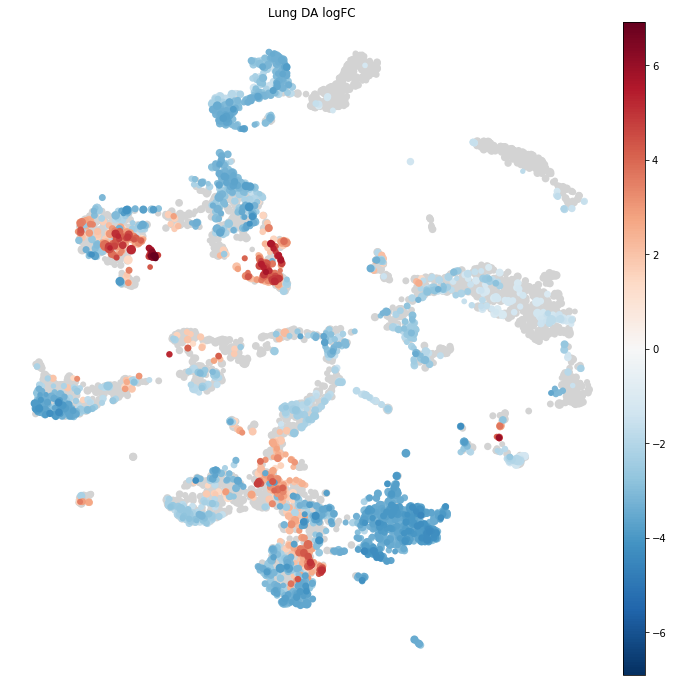

In [105]:
plt.rcParams['figure.figsize'] = [12,12]
nhood_adata = adata.uns['nhood_adata'].copy()
milopy.plot.plot_nhood_graph(adata, min_logFC = 0.5, min_size=1, title='Lung DA logFC', alpha=0.05)

#### Annotate neighbourhoods using Pan-fetal cell types

In [106]:
is_query = adata.obs["dataset"] == "query"
is_reference = adata.obs["dataset"] == "reference"

adata.obs['merged_anno'] = np.nan
adata.obs.loc[is_reference, 'merged_anno'] = adata.obs.loc[is_reference, 'celltype_annotation']
adata.obs.loc[is_query, 'merged_anno'] = adata.obs.loc[is_query, 'predicted_anno']

milopy.utils.annotate_nhoods(adata, anno_col='merged_anno')

In [107]:
nhood_adata = adata.uns['nhood_adata'].copy()
pl_df = nhood_adata.obs.copy()

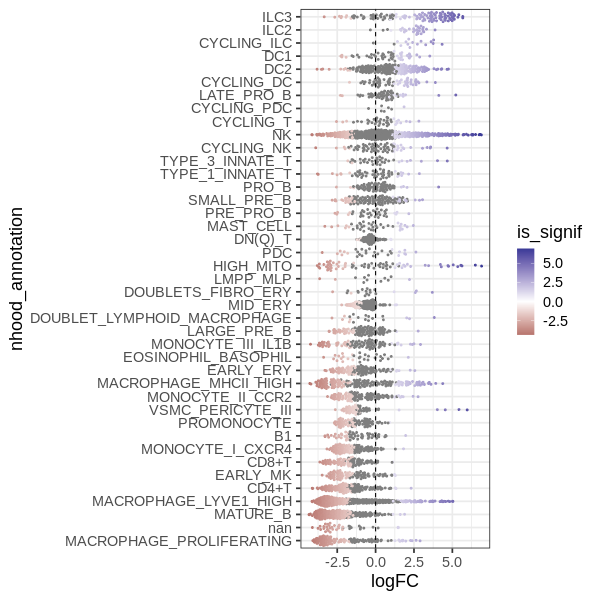

In [108]:
%%R -i pl_df -h 600 -w 600
pl_df %>%
    mutate(is_signif = ifelse(SpatialFDR < 0.1, logFC, NA)) %>%
    group_by(nhood_annotation) %>%
    filter(any((logFC > 0) & is_signif)) %>%
    mutate(median_FC = median(logFC)) %>%
    ungroup() %>%
    arrange(median_FC) %>%
    mutate(nhood_annotation = factor(nhood_annotation, levels=unique(nhood_annotation))) %>%
    ggplot(aes(nhood_annotation, logFC)) +
    ggbeeswarm::geom_quasirandom(aes(color=is_signif), size=0.7) +
    scale_color_gradient2() +
    coord_flip() +
    geom_hline(yintercept=0, linetype=2) +
    theme_bw(base_size=18)


### Which lung cell types are found in lung specific neighbourhoods?

In [112]:
milopy.utils.annotate_nhoods(adata, anno_col='celltype')

In [113]:
nhood_adata = adata.uns['nhood_adata'].copy()
pl_df = nhood_adata.obs.copy()

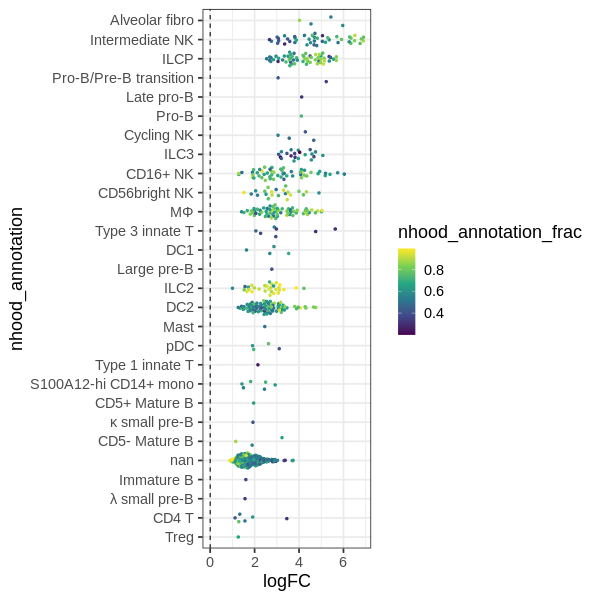

In [114]:
%%R -i pl_df -h 600 -w 600
pl_df %>%
    filter(SpatialFDR < 0.1 & logFC > 0) %>% ## Restrict to nhoods enriched in lung cells
    mutate(is_signif = ifelse(SpatialFDR < 0.1, logFC, NA)) %>%
    group_by(nhood_annotation) %>%
    filter(any((logFC > 0) & is_signif)) %>%
    mutate(median_FC = median(logFC)) %>%
    ungroup() %>%
    arrange(median_FC) %>%
    mutate(nhood_annotation = factor(nhood_annotation, levels=unique(nhood_annotation))) %>%
    ggplot(aes(nhood_annotation, logFC)) +
    ggbeeswarm::geom_quasirandom(aes(color=nhood_annotation_frac), size=1) +
    scale_color_viridis_c() +
    coord_flip() +
    geom_hline(yintercept=0, linetype=2) +
    theme_bw(base_size=18)


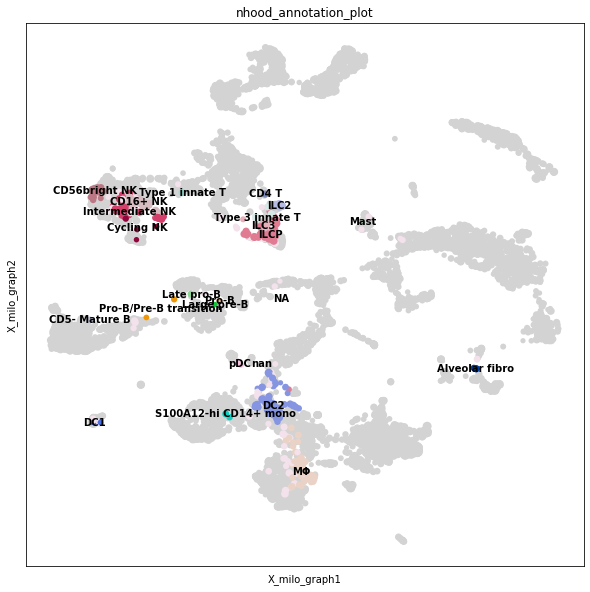

In [116]:
min_size=1
signif_nhoods = pl_df.index[(pl_df['logFC'] > 2) & (pl_df['SpatialFDR'] < 0.1)]

nhood_adata.obs['nhood_annotation_plot'] = np.nan
nhood_adata.obs.loc[signif_nhoods,'nhood_annotation_plot'] = nhood_adata.obs.loc[signif_nhoods,'nhood_annotation']

plt.rcParams['figure.figsize'] = [10,10]
sc.pl.embedding(nhood_adata, 'X_milo_graph', color='nhood_annotation_plot', legend_loc='on data', size=adata.uns["nhood_adata"].obs["Nhood_size"]*min_size)

### Save milo outputs

In [117]:
## Save processed anndata object
nhood_adata = adata.uns["nhood_adata"].copy()
del adata.uns["nhood_adata"]

In [118]:
adata.write_h5ad("/nfs/team205/ed6/data/lunLung_panfetal_merged.scVI.V3.4milo.h5ad")

In [119]:
nhood_adata.uns["annotation_labels"] = nhood_adata.uns["annotation_labels"].tolist()
nhood_adata.write_h5ad("/nfs/team205/ed6/data/Fetal_immune/Lung_panfetal_merged.scVI.V3.nhood_adata.h5ad")

### Make figures

In [13]:
import matplotlib

In [15]:
figdir = '/home/jovyan/mount/gdrive/fetal_immune_lung_intergration/figures/'
if not os.path.exists(figdir):
    os.mkdir(figdir)
# scv.settings.figdir = figdir
sc.settings.figdir = figdir

In [16]:
nhood_adata = sc.read_h5ad("/nfs/team205/ed6/data/Fetal_immune/Lung_panfetal_merged.scVI.V3.nhood_adata.h5ad")

In [17]:
adata = sc.read_h5ad("/nfs/team205/ed6/data/lunLung_panfetal_merged.scVI.V3.4milo.h5ad", backed=False)

### Bee-swarm plot with lung annotations

In [18]:
adata.uns['nhood_adata'] = nhood_adata.copy()

In [19]:
milopy.utils.annotate_nhoods(adata[adata.obs['dataset_DA'] == 1], anno_col='celltype')

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)


In [20]:
nhood_adata = adata.uns['nhood_adata'].copy()
pl_df = nhood_adata.obs.copy()

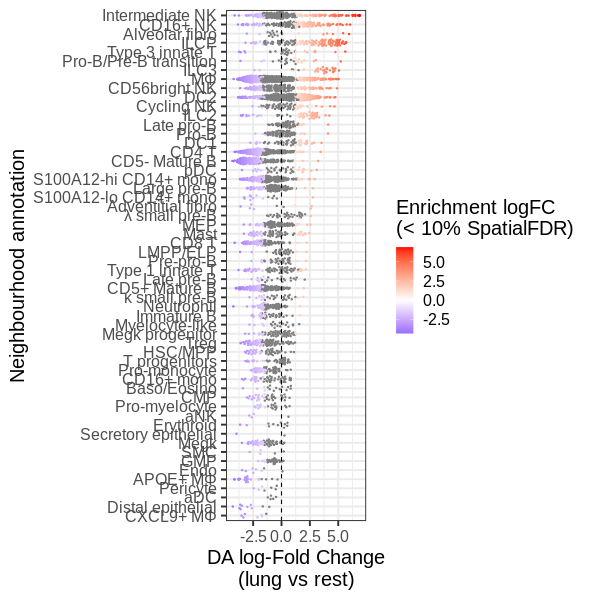

In [13]:
%%R -i pl_df -h 600 -w 600 -i figdir
pl_df %>%
    filter(!is.na(nhood_annotation)) %>%
    mutate(is_signif = ifelse((SpatialFDR < 0.1), logFC, NA)) %>%
    group_by(nhood_annotation) %>%
#     filter(any((logFC > 0) & is_signif)) %>%
    mutate(median_FC = max(logFC)) %>%
    ungroup() %>%
    arrange(median_FC) %>%
    mutate(nhood_annotation = factor(nhood_annotation, levels=unique(nhood_annotation))) %>%
    ggplot(aes(nhood_annotation, logFC)) +
    ggbeeswarm::geom_quasirandom(aes(color=is_signif), size=0.5) +
    scale_color_gradient2(high='red', low = 'blue', name='Enrichment logFC\n(< 10% SpatialFDR) ') +
    coord_flip() +
    geom_hline(yintercept=0, linetype=2) +
    xlab("Neighbourhood annotation") + ylab("DA log-Fold Change\n(lung vs rest)") +
    theme_bw(base_size=20) +
    ggsave(paste0(figdir, 'beeswarm_lung_anno.pdf'), height=20, width=10, device = cairo_pdf) +
    ggsave(paste0(figdir, 'beeswarm_lung_anno.png'), height=20, width=10)


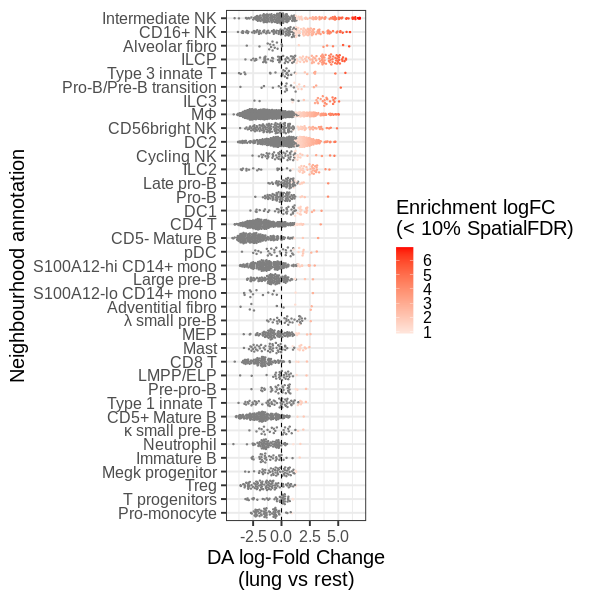

In [15]:
%%R -i pl_df -h 600 -w 600 -i figdir
pl_df %>%
    filter(!is.na(nhood_annotation)) %>%
    mutate(is_signif = ifelse((SpatialFDR < 0.1) & (logFC > 0), logFC, NA)) %>%
    group_by(nhood_annotation) %>%
    filter(any((logFC > 0) & is_signif)) %>%
    mutate(median_FC = max(logFC)) %>%
    ungroup() %>%
    arrange(median_FC) %>%
    mutate(nhood_annotation = factor(nhood_annotation, levels=unique(nhood_annotation))) %>%
    ggplot(aes(nhood_annotation, logFC)) +
    ggbeeswarm::geom_quasirandom(aes(color=is_signif), size=0.5) +
    scale_color_gradient2(high='red', name='Enrichment logFC\n(< 10% SpatialFDR) ') +
    coord_flip() +
    geom_hline(yintercept=0, linetype=2) +
    xlab("Neighbourhood annotation") + ylab("DA log-Fold Change\n(lung vs rest)") +
    theme_bw(base_size=20) +
    ggsave(paste0(figdir, 'beeswarm_lung_anno.signif_enrich.pdf'), height=15, width=10, device = cairo_pdf) +
    ggsave(paste0(figdir, 'beeswarm_lung_anno.signif_enrich.png'), height=15, width=10)


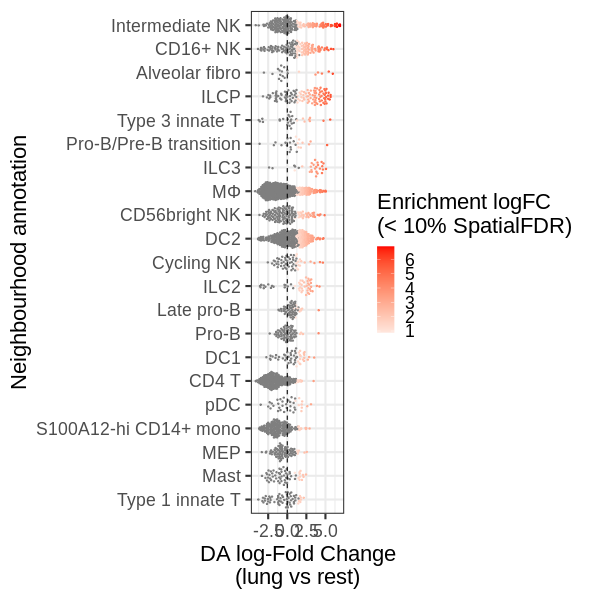

In [16]:
%%R -i pl_df -h 600 -w 600 -i figdir
pl_df %>%
    filter(!is.na(nhood_annotation)) %>%
    mutate(is_signif = ifelse((SpatialFDR < 0.1) & (logFC > 0), logFC, NA)) %>%
    group_by(nhood_annotation) %>%
    mutate(n_enriched = sum((logFC > 0) & !is.na(is_signif))) %>%
    filter(n_enriched > 3) %>%
    mutate(median_FC = max(logFC)) %>%
    ungroup() %>%
    arrange(median_FC) %>%
    mutate(nhood_annotation = factor(nhood_annotation, levels=unique(nhood_annotation))) %>%
    ggplot(aes(nhood_annotation, logFC)) +
    ggbeeswarm::geom_quasirandom(aes(color=is_signif), size=0.5) +
    scale_color_gradient2(high='red', name='Enrichment logFC\n(< 10% SpatialFDR) ') +
    coord_flip() +
    geom_hline(yintercept=0, linetype=2) +
    xlab("Neighbourhood annotation") + ylab("DA log-Fold Change\n(lung vs rest)") +
    theme_bw(base_size=22) +
    ggsave(paste0(figdir, 'beeswarm_lung_anno.signif_enrich.pdf'), height=10, width=10, device = cairo_pdf) +
    ggsave(paste0(figdir, 'beeswarm_lung_anno.signif_enrich.png'), height=10, width=10)


### Plot for integration 

saving figure to file /home/jovyan/mount/gdrive/fetal_immune_lung_intergration/figures/scvelo_lung_annotations_labels_on_data.png


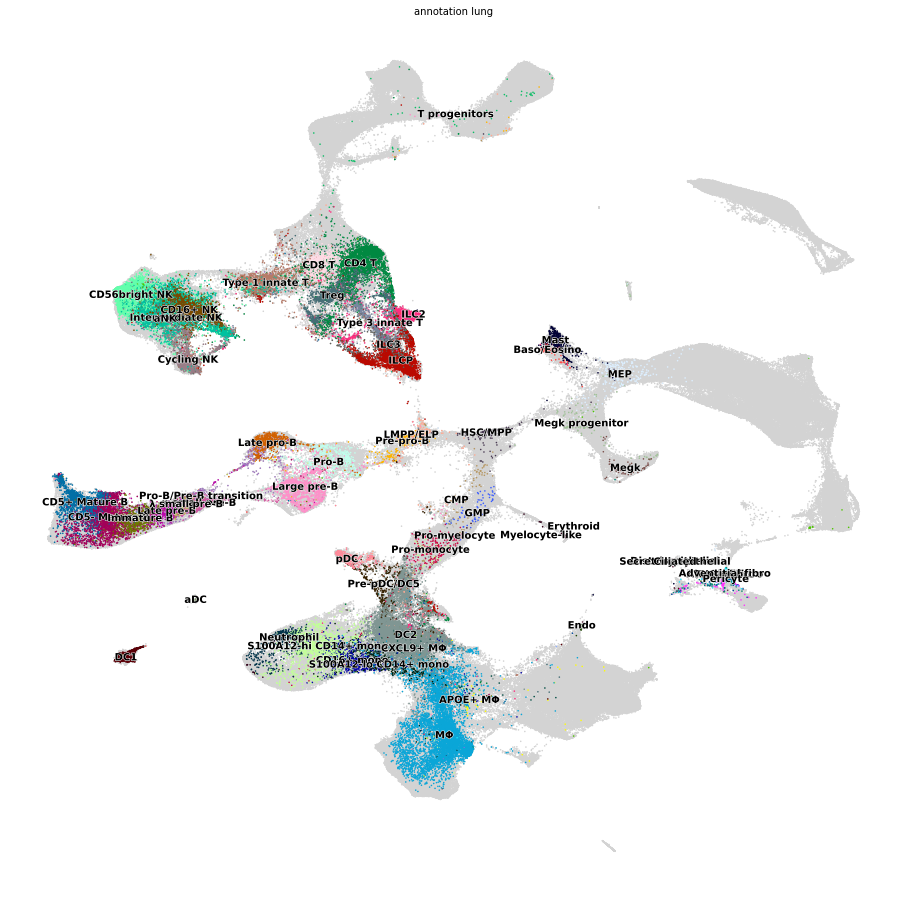

In [12]:
labels = [x for x in adata.obs['celltype'].unique().tolist() if x != 'nan']
sns.set_context('talk')
with matplotlib.rc_context({'figure.figsize':[16,16]}):
    scv.pl.umap(adata,color=['celltype'], size=10, groups=labels,
         title=['annotation lung'], legend_loc='on data', ncols=1, 
                save='lung_annotations_labels_on_data.png');
    

saving figure to file /home/jovyan/mount/gdrive/fetal_immune_lung_intergration/figures/scvelo_lung_annotations_labels_right_margin.png


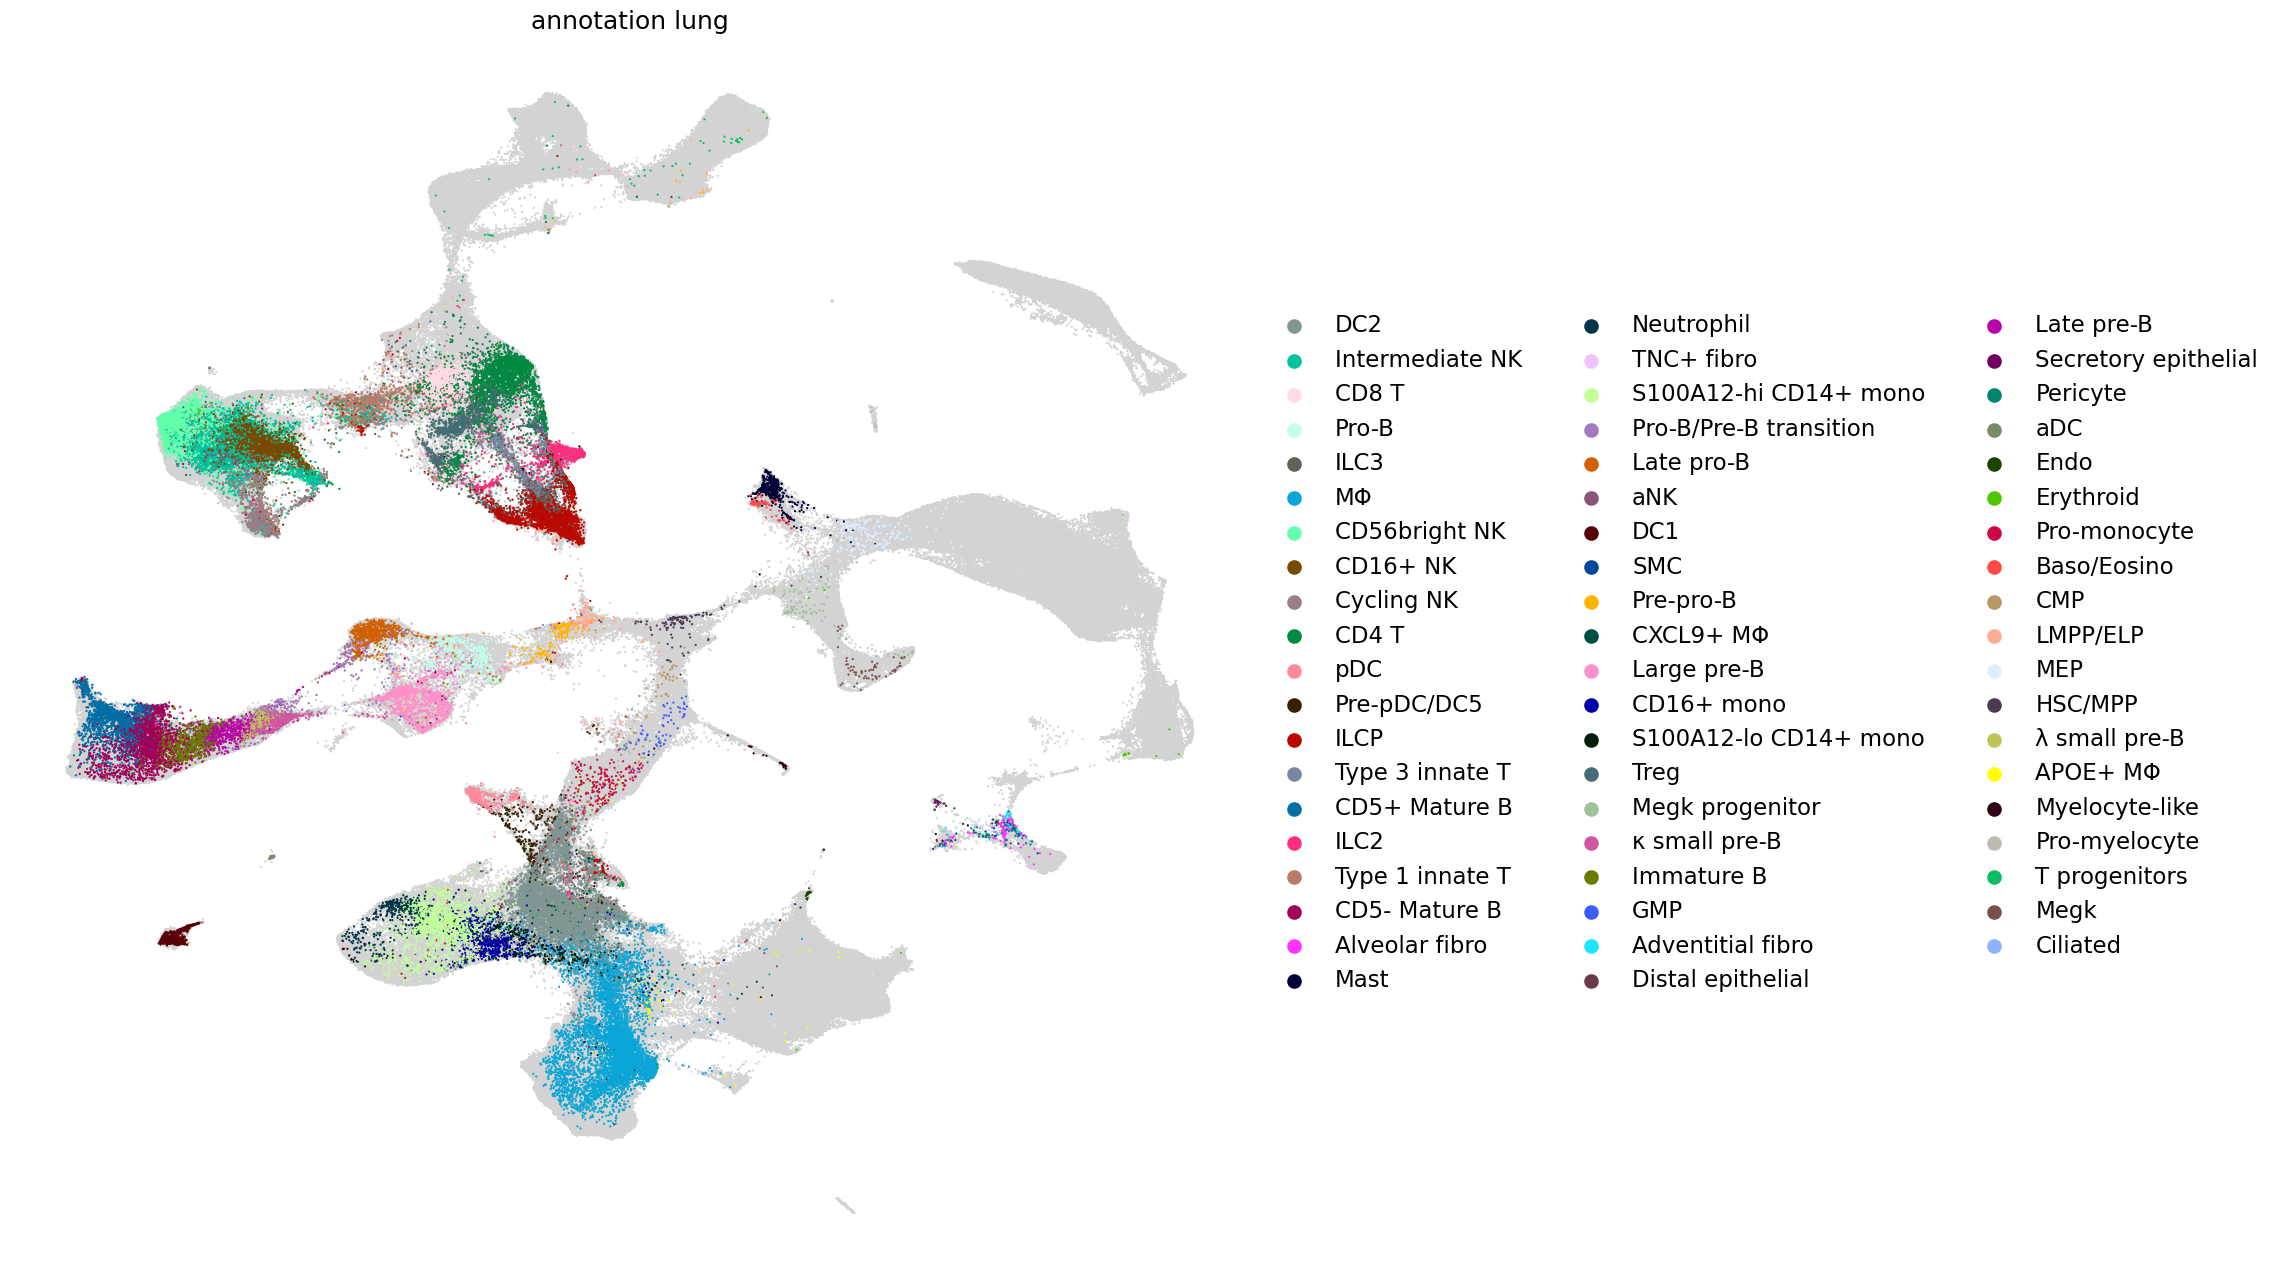

saving figure to file /home/jovyan/mount/gdrive/fetal_immune_lung_intergration/figures/scvelo_lung_annotations_labels_right_margin.pdf


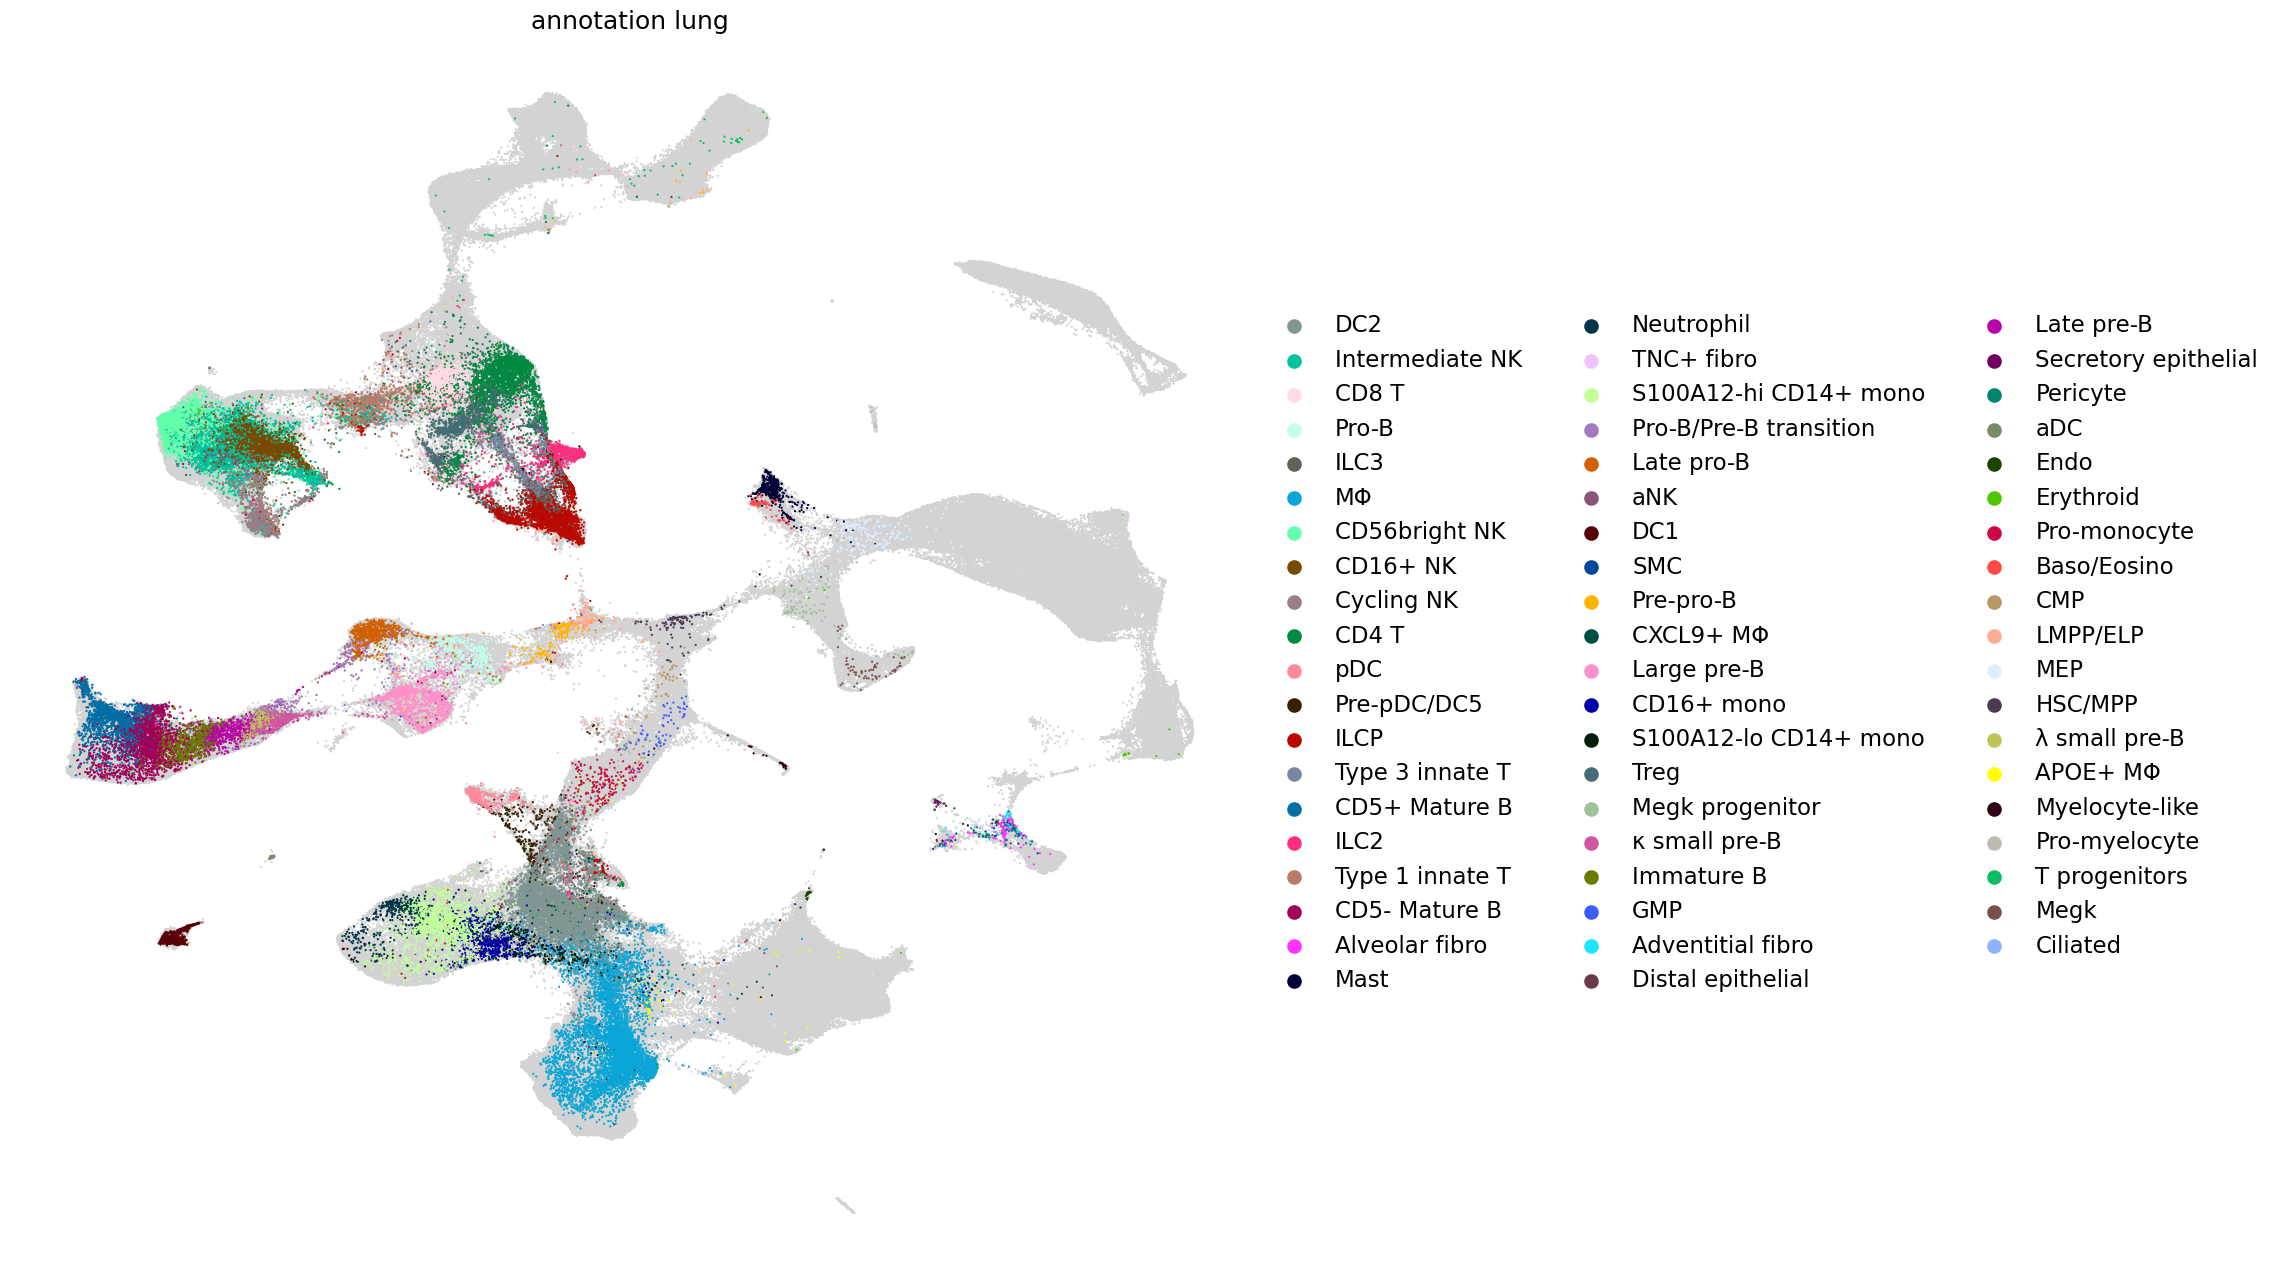

In [13]:
with matplotlib.rc_context({'figure.figsize':[16,16]}):
    scv.pl.umap(adata,color=['celltype'], size=10, groups=labels,
         title=['annotation lung'], legend_loc='right_margin', ncols=1, save='lung_annotations_labels_right_margin.png');
    scv.pl.umap(adata,color=['celltype'], size=10, groups=labels,
         title=['annotation lung'], legend_loc='right_margin', ncols=1, save='lung_annotations_labels_right_margin.pdf');
    